In [1]:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
# nb7 plus 10000

In [2]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

from artgor_utils import *

In [3]:
file_folder = '../data'
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')
scalar_coupling_contributions = pd.read_csv(f'{file_folder}/scalar_coupling_contributions.csv')

In [4]:
from tqdm import tqdm_notebook as tqdm
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

#structures = pd.read_csv(structures, dtype={'atom_index':np.int8})

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

display(structures.head())

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

,molecule_name,atom_index,atom,x,y,z,EN,rad
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958,2.55,0.82
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204,2.20,0.43
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748,2.20,0.43
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152,2.20,0.43
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942,2.20,0.43


In [5]:
i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_name'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating the bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

#bond_data = {'bond_' + str(i):col for i, col in enumerate(np.transpose(bonds))}
#bond_data.update({'bonds_numeric':bonds_numeric, 'n_bonds':n_bonds})

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))

Calculating the bonds


HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Counting and condensing bonds


HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

,molecule_name,atom_index,atom,x,y,z,EN,rad,bond_lengths_mean,n_bonds
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958,2.55,0.82,1.091949701309204,4
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204,2.20,0.43,1.091953039169312,1
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748,2.20,0.43,1.091951608657837,1
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152,2.20,0.43,1.091946363449097,1
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942,2.20,0.43,1.091947555541992,1
5,dsgdb9nsd_000002,0,N,-0.0404260543,1.0241077530,0.0625637998,3.04,0.80,1.017194986343384,3
6,dsgdb9nsd_000002,1,H,0.0172574639,0.0125452063,-0.0273771593,2.20,0.43,1.017189979553223,1
7,dsgdb9nsd_000002,2,H,0.9157893661,1.3587451950,-0.0287577581,2.20,0.43,1.017187237739563,1
8,dsgdb9nsd_000002,3,H,-0.5202777357,1.3435321260,-0.7755426124,2.20,0.43,1.017207860946655,1
9,dsgdb9nsd_000003,0,O,-0.0343604951,0.9775395708,0.0076015923,3.44,0.78,0.962106823921204,2


In [6]:
train = pd.merge(train, scalar_coupling_contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [7]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [8]:
train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [9]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [10]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

In [11]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 470.89 Mb (59.8% reduction)
Mem. usage decreased to 229.39 Mb (57.1% reduction)


In [12]:
def create_features_full(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_median'] = df.groupby('molecule_name')['dist'].transform('median')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['molecule_dist_std'] = df.groupby('molecule_name')['dist'].transform('std')
    
    
    
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['type_0_couples_count'] = df.groupby(['molecule_name', 'type_0'])['id'].transform('count')
    df['type_1_couples_count'] = df.groupby(['molecule_name', 'type_1'])['id'].transform('count')
    
#     df['molecule_distx_mean'] = df.groupby('molecule_name')['dist_x'].transform('mean')
#     df['molecule_distx_median'] = df.groupby('molecule_name')['dist_x'].transform('median')
#     df['molecule_distx_min'] = df.groupby('molecule_name')['dist_x'].transform('min')
#     df['molecule_distx_max'] = df.groupby('molecule_name')['dist_x'].transform('max')
#     df['molecule_distx_std'] = df.groupby('molecule_name')['dist_x'].transform('std')
    
    
    
#     df['molecule_disty_mean'] = df.groupby('molecule_name')['dist_y'].transform('mean')
#     df['molecule_disty_median'] = df.groupby('molecule_name')['dist_y'].transform('median')
#     df['molecule_disty_min'] = df.groupby('molecule_name')['dist_y'].transform('min')
#     df['molecule_disty_max'] = df.groupby('molecule_name')['dist_y'].transform('max')
#     df['molecule_disty_std'] = df.groupby('molecule_name')['dist_y'].transform('std')
   
   
    
    
#     df['molecule_distz_mean'] = df.groupby('molecule_name')['dist_z'].transform('mean')
#     df['molecule_distz_median'] = df.groupby('molecule_name')['dist_z'].transform('median')
#     df['molecule_distz_min'] = df.groupby('molecule_name')['dist_z'].transform('min')
#     df['molecule_distz_max'] = df.groupby('molecule_name')['dist_z'].transform('max')
#     df['molecule_distz_std'] = df.groupby('molecule_name')['dist_z'].transform('std')
    
   
    
    
    num_cols = ['x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z']
    cat_cols = ['atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0']
    aggs = ['mean', 'max', 'std', 'min', 'skew', 'median']
    for col in cat_cols:
        df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

    for cat_col in tqdm_notebook(cat_cols):
        for num_col in num_cols:
            for agg in aggs:
                df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
                df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]
#                 df[f'molecule_{cat_col}_{num_col}_{agg}_sum'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] + df[num_col]
#                 df[f'molecule_{cat_col}_{num_col}_{agg}_mult'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] * df[num_col]


    df = reduce_mem_usage(df)
    return df

In [13]:
train = create_features_full(train)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 10261.92 Mb (-56.9% reduction)


In [14]:
test = create_features_full(test)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 5489.76 Mb (-57.4% reduction)


In [15]:
# train.to_csv('../cache/train2.csv', index=False)
# test.to_csv('../cache/test2.csv', index=False)

In [16]:
# train = pd.read_csv('../cache/train2.csv')
# test = pd.read_csv('../cache/test2.csv')

In [17]:
for f in ['atom_index_0', 'atom_index_1', 'atom_1', 'type_0', 'type', 'atom_0', 'type_1']:
#     if f in good_columns:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [18]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

In [19]:
good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type',
'EN_x', 'rad_x',
'n_bonds_x', 'bond_lengths_mean_x','EN_y', 'rad_y', 'n_bonds_y', 'bond_lengths_mean_y'
]

In [20]:
# for f in ['atom_0', 'type_1']:
# #     if f in good_columns:
#     lbl = LabelEncoder()
#     lbl.fit(list(X[f].values) + list(X_test[f].values))
#     X[f] = lbl.transform(list(X[f].values))
#     X_test[f] = lbl.transform(list(X_test[f].values))

In [21]:
# X = train[good_columns].copy()
# y = train['scalar_coupling_constant']
# X_test = test[good_columns].copy()

In [22]:
# X = train.copy()
# y = train['scalar_coupling_constant']
# del train

# X_test = test.copy()
# del test
# del structures

In [23]:
# X = X.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)

# X_test = X_test.drop(['id', 'molecule_name'], axis=1)

In [24]:
X = train[good_columns].copy()
y1 = train['scalar_coupling_constant']
y_fc = train['fc']
y_sd = train['sd']
y_pso = train['pso']
y_dso = train['dso']
X_test = test[good_columns].copy()

In [25]:
del train, test

In [26]:
import gc
gc.collect()

857

In [27]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [28]:
# params = {'num_leaves': 128,
#           'min_child_samples': 79,
#           'objective': 'regression',
#           'max_depth': 9,
#           'learning_rate': 0.2,
#           "boosting_type": "gbdt",
#           "subsample_freq": 1,
#           "subsample": 0.9,
#           "bagging_seed": 11,
#           "metric": 'mae',
#           "verbosity": -1,
#           'reg_alpha': 0.1,
#           'reg_lambda': 0.3,
#           'colsample_bytree': 1.0
#          }
# result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [29]:
y = y_fc
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [30]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=10000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
# sub['scalar_coupling_constant'] = X_short_test['prediction']
# sub.to_csv('../submissions/sub5.csv', index=False)
# sub.head()

Training of type 0
Fold 1 started at Sat Jun 22 15:50:32 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.32255	valid_1's l1: 1.57315
[1000]	training's l1: 1.07318	valid_1's l1: 1.47001
[1500]	training's l1: 0.906118	valid_1's l1: 1.42193
[2000]	training's l1: 0.782917	valid_1's l1: 1.39242
[2500]	training's l1: 0.685176	valid_1's l1: 1.37309
[3000]	training's l1: 0.603938	valid_1's l1: 1.35914
[3500]	training's l1: 0.536901	valid_1's l1: 1.34987
[4000]	training's l1: 0.47887	valid_1's l1: 1.34264
[4500]	training's l1: 0.429063	valid_1's l1: 1.33782
[5000]	training's l1: 0.386093	valid_1's l1: 1.33331
[5500]	training's l1: 0.348192	valid_1's l1: 1.32972
[6000]	training's l1: 0.31476	valid_1's l1: 1.32699
[6500]	training's l1: 0.285306	valid_1's l1: 1.32456
[7000]	training's l1: 0.259105	valid_1's l1: 1.32266
[7500]	training's l1: 0.235801	valid_1's l1: 1.32088
[8000]	training's l1: 0.215016	valid_1's l1: 1.31948
[8500]	training's l1: 0.196281	v

[4500]	training's l1: 0.053148	valid_1's l1: 0.330709
[5000]	training's l1: 0.0452519	valid_1's l1: 0.330141
[5500]	training's l1: 0.0387402	valid_1's l1: 0.32977
[6000]	training's l1: 0.0331966	valid_1's l1: 0.32944
[6500]	training's l1: 0.0285868	valid_1's l1: 0.329139
[7000]	training's l1: 0.0246927	valid_1's l1: 0.32896
[7500]	training's l1: 0.0214149	valid_1's l1: 0.328842
[8000]	training's l1: 0.01862	valid_1's l1: 0.328696
[8500]	training's l1: 0.016261	valid_1's l1: 0.328598
[9000]	training's l1: 0.0142381	valid_1's l1: 0.328529
[9500]	training's l1: 0.0125144	valid_1's l1: 0.328473
[10000]	training's l1: 0.01105	valid_1's l1: 0.328423
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.01105	valid_1's l1: 0.328423
Fold 3 started at Sat Jun 22 16:38:44 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.275422	valid_1's l1: 0.37572
[1000]	training's l1: 0.207346	valid_1's l1: 0.35491
[1500]	training's l1: 0.162734	vali

[500]	training's l1: 0.193574	valid_1's l1: 0.367001
[1000]	training's l1: 0.112285	valid_1's l1: 0.352297
[1500]	training's l1: 0.0707309	valid_1's l1: 0.347282
[2000]	training's l1: 0.0454747	valid_1's l1: 0.34486
[2500]	training's l1: 0.0299215	valid_1's l1: 0.343777
[3000]	training's l1: 0.0201789	valid_1's l1: 0.343016
[3500]	training's l1: 0.0137848	valid_1's l1: 0.342638
[4000]	training's l1: 0.00970502	valid_1's l1: 0.342381
[4500]	training's l1: 0.00705933	valid_1's l1: 0.342235
[5000]	training's l1: 0.00532804	valid_1's l1: 0.342151
[5500]	training's l1: 0.00418232	valid_1's l1: 0.342089
[6000]	training's l1: 0.00339395	valid_1's l1: 0.342056
[6500]	training's l1: 0.0028349	valid_1's l1: 0.342029
[7000]	training's l1: 0.00242217	valid_1's l1: 0.342009
[7500]	training's l1: 0.00211905	valid_1's l1: 0.341998
[8000]	training's l1: 0.00188903	valid_1's l1: 0.341991
[8500]	training's l1: 0.00171853	valid_1's l1: 0.341983
[9000]	training's l1: 0.00158659	valid_1's l1: 0.341976
[950

[5000]	training's l1: 0.247849	valid_1's l1: 0.63768
[5500]	training's l1: 0.228272	valid_1's l1: 0.63475
[6000]	training's l1: 0.21082	valid_1's l1: 0.632204
[6500]	training's l1: 0.195008	valid_1's l1: 0.629986
[7000]	training's l1: 0.180881	valid_1's l1: 0.627995
[7500]	training's l1: 0.167971	valid_1's l1: 0.626229
[8000]	training's l1: 0.156116	valid_1's l1: 0.624746
[8500]	training's l1: 0.14528	valid_1's l1: 0.623521
[9000]	training's l1: 0.13536	valid_1's l1: 0.622464
[9500]	training's l1: 0.126312	valid_1's l1: 0.621442
[10000]	training's l1: 0.117876	valid_1's l1: 0.620464
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.117876	valid_1's l1: 0.620464
Fold 3 started at Sat Jun 22 17:29:51 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.696275	valid_1's l1: 0.79419
[1000]	training's l1: 0.57483	valid_1's l1: 0.731119
[1500]	training's l1: 0.497563	valid_1's l1: 0.700866
[2000]	training's l1: 0.439855	valid_1's l

[9000]	training's l1: 0.0332285	valid_1's l1: 0.354617
[9500]	training's l1: 0.029996	valid_1's l1: 0.354395
[10000]	training's l1: 0.0271188	valid_1's l1: 0.354217
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.0271188	valid_1's l1: 0.354217
Fold 4 started at Sat Jun 22 18:22:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.346686	valid_1's l1: 0.426953
[1000]	training's l1: 0.270818	valid_1's l1: 0.396192
[1500]	training's l1: 0.222473	valid_1's l1: 0.382189
[2000]	training's l1: 0.187538	valid_1's l1: 0.374525
[2500]	training's l1: 0.160375	valid_1's l1: 0.369134
[3000]	training's l1: 0.138745	valid_1's l1: 0.365427
[3500]	training's l1: 0.120752	valid_1's l1: 0.362833
[4000]	training's l1: 0.105686	valid_1's l1: 0.36088
[4500]	training's l1: 0.0929537	valid_1's l1: 0.359324
[5000]	training's l1: 0.0822121	valid_1's l1: 0.3582
[5500]	training's l1: 0.0728661	valid_1's l1: 0.357202
[6000]	training's l1: 0.0648193	

[1000]	training's l1: 0.656127	valid_1's l1: 0.785324
[1500]	training's l1: 0.579479	valid_1's l1: 0.749174
[2000]	training's l1: 0.520778	valid_1's l1: 0.72551
[2500]	training's l1: 0.474331	valid_1's l1: 0.709135
[3000]	training's l1: 0.435488	valid_1's l1: 0.697649
[3500]	training's l1: 0.401331	valid_1's l1: 0.688385
[4000]	training's l1: 0.371772	valid_1's l1: 0.680982
[4500]	training's l1: 0.345434	valid_1's l1: 0.674896
[5000]	training's l1: 0.321975	valid_1's l1: 0.669921
[5500]	training's l1: 0.301165	valid_1's l1: 0.6657
[6000]	training's l1: 0.28193	valid_1's l1: 0.662126
[6500]	training's l1: 0.264588	valid_1's l1: 0.659102
[7000]	training's l1: 0.248577	valid_1's l1: 0.656498
[7500]	training's l1: 0.233838	valid_1's l1: 0.654092
[8000]	training's l1: 0.220414	valid_1's l1: 0.652112
[8500]	training's l1: 0.207813	valid_1's l1: 0.6503
[9000]	training's l1: 0.196094	valid_1's l1: 0.648558
[9500]	training's l1: 0.185136	valid_1's l1: 0.646983
[10000]	training's l1: 0.175061	va

In [31]:
oof_fc = X_short['oof'].values
test_oof_fc = X_short_test['prediction'].values

Fold 1 started at Sat Jun 22 20:01:20 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.00615	valid_1's l1: 1.04248
[1000]	training's l1: 0.886882	valid_1's l1: 0.949517
[1500]	training's l1: 0.814038	valid_1's l1: 0.898969
[2000]	training's l1: 0.761523	valid_1's l1: 0.86607
[2500]	training's l1: 0.719918	valid_1's l1: 0.84223
[3000]	training's l1: 0.685009	valid_1's l1: 0.823885
[3500]	training's l1: 0.654431	valid_1's l1: 0.808632
[4000]	training's l1: 0.627831	valid_1's l1: 0.796263
[4500]	training's l1: 0.603955	valid_1's l1: 0.785832
[5000]	training's l1: 0.582266	valid_1's l1: 0.77683
[5500]	training's l1: 0.562278	valid_1's l1: 0.769088
[6000]	training's l1: 0.544226	valid_1's l1: 0.762542
[6500]	training's l1: 0.527092	valid_1's l1: 0.756428
[7000]	training's l1: 0.511242	valid_1's l1: 0.750859
[7500]	training's l1: 0.496251	valid_1's l1: 0.745882
[8000]	training's l1: 0.482217	valid_1's l1: 0.741415
[8500]	training's l1: 0.468932	valid

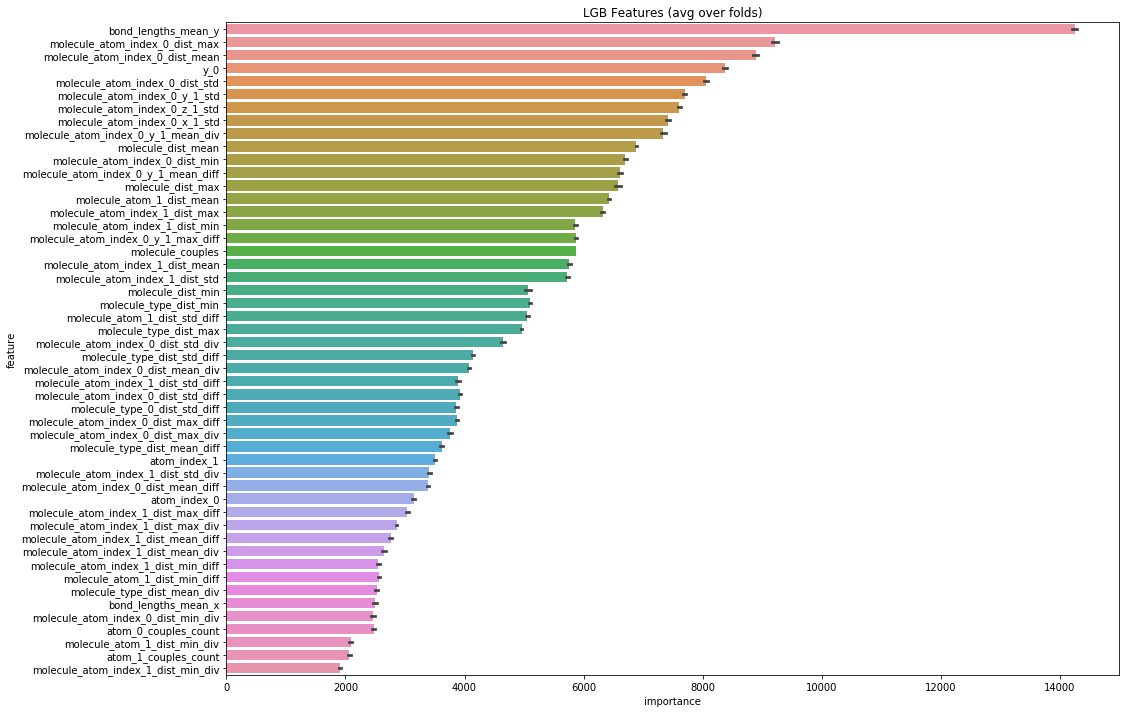

In [32]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb1 = train_model_regression(X=X, X_test=X_test, y=y_fc, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=10000)

In [33]:
oof_fc = result_dict_lgb1['oof']
test_oof_fc = result_dict_lgb1['prediction']

In [34]:
y = y_sd
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [35]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=10000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    

Training of type 0
Fold 1 started at Sat Jun 22 23:06:42 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00865452	valid_1's l1: 0.0103397
[1000]	training's l1: 0.00692473	valid_1's l1: 0.0095368
[1500]	training's l1: 0.00584941	valid_1's l1: 0.0091497
[2000]	training's l1: 0.00507295	valid_1's l1: 0.00892442
[2500]	training's l1: 0.00447507	valid_1's l1: 0.00877857
[3000]	training's l1: 0.00399922	valid_1's l1: 0.00867349
[3500]	training's l1: 0.00361086	valid_1's l1: 0.00859595
[4000]	training's l1: 0.00328951	valid_1's l1: 0.00853812
[4500]	training's l1: 0.00301625	valid_1's l1: 0.00849404
[5000]	training's l1: 0.00278212	valid_1's l1: 0.00845531
[5500]	training's l1: 0.00258227	valid_1's l1: 0.00842617
[6000]	training's l1: 0.00240742	valid_1's l1: 0.00840197
[6500]	training's l1: 0.00225354	valid_1's l1: 0.00838263
[7000]	training's l1: 0.00211871	valid_1's l1: 0.00836522
[7500]	training's l1: 0.00199916	valid_1's l1: 0.00835242
[8000]	tr

Fold 2 started at Sat Jun 22 23:58:19 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00390615	valid_1's l1: 0.00509985
[1000]	training's l1: 0.00294522	valid_1's l1: 0.00472766
[1500]	training's l1: 0.00240817	valid_1's l1: 0.00458022
[2000]	training's l1: 0.0020514	valid_1's l1: 0.00449901
[2500]	training's l1: 0.00179513	valid_1's l1: 0.00445094
[3000]	training's l1: 0.0016031	valid_1's l1: 0.00441627
[3500]	training's l1: 0.00145248	valid_1's l1: 0.00439452
[4000]	training's l1: 0.00133251	valid_1's l1: 0.00437821
[4500]	training's l1: 0.00123369	valid_1's l1: 0.00436502
[5000]	training's l1: 0.0011532	valid_1's l1: 0.0043558
[5500]	training's l1: 0.0010857	valid_1's l1: 0.00434925
[6000]	training's l1: 0.00102845	valid_1's l1: 0.0043434
[6500]	training's l1: 0.000980332	valid_1's l1: 0.00433976
[7000]	training's l1: 0.000938743	valid_1's l1: 0.00433588
[7500]	training's l1: 0.000904839	valid_1's l1: 0.00433283
[8000]	training's l1: 0.0008

[500]	training's l1: 0.00253717	valid_1's l1: 0.00609458
[1000]	training's l1: 0.00180076	valid_1's l1: 0.00598067
[1500]	training's l1: 0.0015484	valid_1's l1: 0.00595444
[2000]	training's l1: 0.0014171	valid_1's l1: 0.00594153
[2500]	training's l1: 0.00132929	valid_1's l1: 0.00593654
[3000]	training's l1: 0.00126602	valid_1's l1: 0.00593329
[3500]	training's l1: 0.00121684	valid_1's l1: 0.00592971
[4000]	training's l1: 0.00117747	valid_1's l1: 0.00592568
[4500]	training's l1: 0.00114385	valid_1's l1: 0.00592384
Early stopping, best iteration is:
[4395]	training's l1: 0.00115034	valid_1's l1: 0.00592299
CV mean score: -5.1309, std: 0.0105.
Training of type 4
Fold 1 started at Sun Jun 23 00:24:19 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00343742	valid_1's l1: 0.00516627
[1000]	training's l1: 0.0022045	valid_1's l1: 0.00479461
[1500]	training's l1: 0.00159359	valid_1's l1: 0.00467097
[2000]	training's l1: 0.00130148	valid_1's l1: 0.00461

[5500]	training's l1: 0.00384805	valid_1's l1: 0.00992917
[6000]	training's l1: 0.00359764	valid_1's l1: 0.0098789
[6500]	training's l1: 0.00337561	valid_1's l1: 0.00983584
[7000]	training's l1: 0.00317805	valid_1's l1: 0.00980071
[7500]	training's l1: 0.00299828	valid_1's l1: 0.00976913
[8000]	training's l1: 0.00283613	valid_1's l1: 0.00974325
[8500]	training's l1: 0.00268854	valid_1's l1: 0.00972019
[9000]	training's l1: 0.00255422	valid_1's l1: 0.00969771
[9500]	training's l1: 0.0024309	valid_1's l1: 0.00967926
[10000]	training's l1: 0.00231806	valid_1's l1: 0.00966195
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.00231806	valid_1's l1: 0.00966195
Fold 2 started at Sun Jun 23 00:44:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0111564	valid_1's l1: 0.0126482
[1000]	training's l1: 0.00926503	valid_1's l1: 0.0116311
[1500]	training's l1: 0.00802732	valid_1's l1: 0.011103
[2000]	training's l1: 0.00709119	valid_1

[5500]	training's l1: 0.00157705	valid_1's l1: 0.00572041
[6000]	training's l1: 0.0014761	valid_1's l1: 0.00570502
[6500]	training's l1: 0.00138943	valid_1's l1: 0.00569336
[7000]	training's l1: 0.00131369	valid_1's l1: 0.00568298
[7500]	training's l1: 0.0012474	valid_1's l1: 0.005674
[8000]	training's l1: 0.00118814	valid_1's l1: 0.00566688
[8500]	training's l1: 0.00113504	valid_1's l1: 0.00566005
[9000]	training's l1: 0.00108755	valid_1's l1: 0.0056551
[9500]	training's l1: 0.00104516	valid_1's l1: 0.00565024
[10000]	training's l1: 0.00100642	valid_1's l1: 0.00564626
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.00100642	valid_1's l1: 0.00564626
Fold 3 started at Sun Jun 23 01:51:39 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00552055	valid_1's l1: 0.0070332
[1000]	training's l1: 0.00429227	valid_1's l1: 0.00649301
[1500]	training's l1: 0.00354848	valid_1's l1: 0.00623757
[2000]	training's l1: 0.00303449	valid_

[5000]	training's l1: 0.00365523	valid_1's l1: 0.00723432
[5500]	training's l1: 0.00345427	valid_1's l1: 0.00718877
[6000]	training's l1: 0.003271	valid_1's l1: 0.00714714
[6500]	training's l1: 0.00310556	valid_1's l1: 0.00711002
[7000]	training's l1: 0.00295447	valid_1's l1: 0.00707834
[7500]	training's l1: 0.00281569	valid_1's l1: 0.00705094
[8000]	training's l1: 0.00268977	valid_1's l1: 0.00702668
[8500]	training's l1: 0.00257195	valid_1's l1: 0.00700272
[9000]	training's l1: 0.00246296	valid_1's l1: 0.00698317
[9500]	training's l1: 0.00236333	valid_1's l1: 0.00696657
[10000]	training's l1: 0.00227026	valid_1's l1: 0.00695038
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.00227026	valid_1's l1: 0.00695038
Fold 4 started at Sun Jun 23 03:09:29 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00821968	valid_1's l1: 0.00907531
[1000]	training's l1: 0.00699175	valid_1's l1: 0.00838529
[1500]	training's l1: 0.0062038	val

[4500]	training's l1: 0.000928589	valid_1's l1: 0.00479628
[5000]	training's l1: 0.000894192	valid_1's l1: 0.00479169
[5500]	training's l1: 0.00086569	valid_1's l1: 0.00478838
[6000]	training's l1: 0.000841372	valid_1's l1: 0.0047862
[6500]	training's l1: 0.000820409	valid_1's l1: 0.00478388
[7000]	training's l1: 0.0008021	valid_1's l1: 0.00478183
[7500]	training's l1: 0.000786153	valid_1's l1: 0.00477983
[8000]	training's l1: 0.000771448	valid_1's l1: 0.00477846
[8500]	training's l1: 0.000758401	valid_1's l1: 0.00477694
[9000]	training's l1: 0.000746308	valid_1's l1: 0.00477602
[9500]	training's l1: 0.00073553	valid_1's l1: 0.00477476
[10000]	training's l1: 0.000725519	valid_1's l1: 0.0047737
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.000725519	valid_1's l1: 0.0047737
Fold 5 started at Sun Jun 23 03:52:55 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00317861	valid_1's l1: 0.00520288
[1000]	training's l1: 0.002

In [36]:
oof_sd = X_short['oof'].values
test_oof_sd = X_short_test['prediction'].values

Fold 1 started at Sun Jun 23 03:55:32 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0115287	valid_1's l1: 0.0119543
[1000]	training's l1: 0.0101356	valid_1's l1: 0.0108403
[1500]	training's l1: 0.00933476	valid_1's l1: 0.010282
[2000]	training's l1: 0.00873916	valid_1's l1: 0.00989013
[2500]	training's l1: 0.00827767	valid_1's l1: 0.00961828
[3000]	training's l1: 0.00788981	valid_1's l1: 0.0094013
[3500]	training's l1: 0.00755628	valid_1's l1: 0.00922895
[4000]	training's l1: 0.00726307	valid_1's l1: 0.00908637
[4500]	training's l1: 0.00699879	valid_1's l1: 0.00896523
[5000]	training's l1: 0.00676164	valid_1's l1: 0.00886559
[5500]	training's l1: 0.00653818	valid_1's l1: 0.00876793
[6000]	training's l1: 0.00633712	valid_1's l1: 0.00868546
[6500]	training's l1: 0.00614738	valid_1's l1: 0.00861091
[7000]	training's l1: 0.00597236	valid_1's l1: 0.00854594
[7500]	training's l1: 0.00580648	valid_1's l1: 0.00848483
[8000]	training's l1: 0.00564933

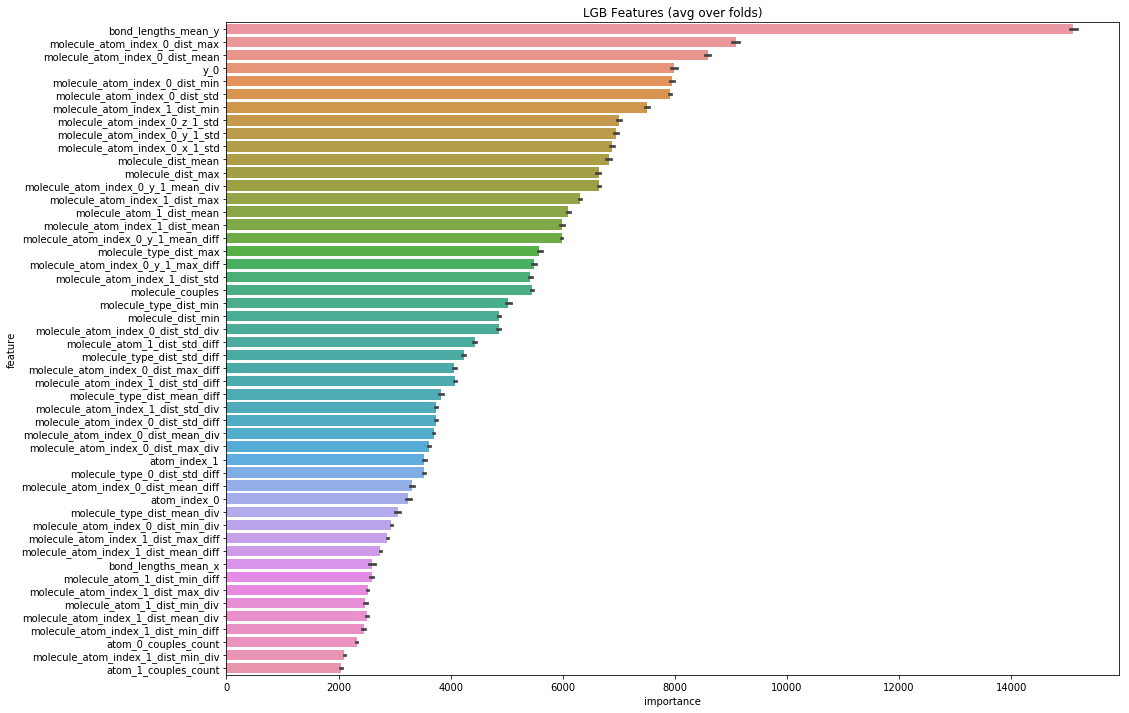

In [37]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb2 = train_model_regression(X=X, X_test=X_test, y=y_sd, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=10000)

In [38]:
oof_sd = result_dict_lgb2['oof']
test_oof_sd = result_dict_lgb2['prediction']

In [39]:
y = y_pso
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [40]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=10000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']

Training of type 0
Fold 1 started at Sun Jun 23 07:15:50 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0388353	valid_1's l1: 0.0467669
[1000]	training's l1: 0.0308887	valid_1's l1: 0.0432187
[1500]	training's l1: 0.0259293	valid_1's l1: 0.0414958
[2000]	training's l1: 0.0222421	valid_1's l1: 0.0404492
[2500]	training's l1: 0.0194022	valid_1's l1: 0.0398003
[3000]	training's l1: 0.0170992	valid_1's l1: 0.0393263
[3500]	training's l1: 0.0151901	valid_1's l1: 0.0389635
[4000]	training's l1: 0.0135889	valid_1's l1: 0.0386969
[4500]	training's l1: 0.0122196	valid_1's l1: 0.0384859
[5000]	training's l1: 0.0110402	valid_1's l1: 0.0383318
[5500]	training's l1: 0.010017	valid_1's l1: 0.0381819
[6000]	training's l1: 0.00912461	valid_1's l1: 0.0380737
[6500]	training's l1: 0.00834502	valid_1's l1: 0.0379877
[7000]	training's l1: 0.00765676	valid_1's l1: 0.037917
[7500]	training's l1: 0.0070452	valid_1's l1: 0.0378559
[8000]	training's l1: 0.00650195	va

[500]	training's l1: 0.0320655	valid_1's l1: 0.0409337
[1000]	training's l1: 0.0238452	valid_1's l1: 0.0378423
[1500]	training's l1: 0.0187387	valid_1's l1: 0.0364876
[2000]	training's l1: 0.0151356	valid_1's l1: 0.0357312
[2500]	training's l1: 0.012447	valid_1's l1: 0.0352142
[3000]	training's l1: 0.0103845	valid_1's l1: 0.0348842
[3500]	training's l1: 0.00877515	valid_1's l1: 0.0346532
[4000]	training's l1: 0.00749858	valid_1's l1: 0.0344655
[4500]	training's l1: 0.00648269	valid_1's l1: 0.0343252
[5000]	training's l1: 0.00564952	valid_1's l1: 0.0342227
[5500]	training's l1: 0.00496874	valid_1's l1: 0.0341415
[6000]	training's l1: 0.00440562	valid_1's l1: 0.0340749
[6500]	training's l1: 0.00394466	valid_1's l1: 0.0340244
[7000]	training's l1: 0.00355091	valid_1's l1: 0.0339814
[7500]	training's l1: 0.00321775	valid_1's l1: 0.0339493
[8000]	training's l1: 0.00293867	valid_1's l1: 0.0339223
[8500]	training's l1: 0.00269775	valid_1's l1: 0.0338998
[9000]	training's l1: 0.0024928	valid_1

[2000]	training's l1: 0.00362319	valid_1's l1: 0.0169949
[2500]	training's l1: 0.002657	valid_1's l1: 0.0168613
[3000]	training's l1: 0.00209921	valid_1's l1: 0.0167981
[3500]	training's l1: 0.00176329	valid_1's l1: 0.0167593
[4000]	training's l1: 0.00155557	valid_1's l1: 0.0167367
[4500]	training's l1: 0.00141695	valid_1's l1: 0.0167246
[5000]	training's l1: 0.00131808	valid_1's l1: 0.0167143
[5500]	training's l1: 0.0012451	valid_1's l1: 0.016708
[6000]	training's l1: 0.00118684	valid_1's l1: 0.0167021
[6500]	training's l1: 0.0011383	valid_1's l1: 0.016697
[7000]	training's l1: 0.00109756	valid_1's l1: 0.0166921
[7500]	training's l1: 0.00106382	valid_1's l1: 0.0166889
[8000]	training's l1: 0.00103372	valid_1's l1: 0.0166854
[8500]	training's l1: 0.00100756	valid_1's l1: 0.0166831
[9000]	training's l1: 0.00098455	valid_1's l1: 0.0166809
[9500]	training's l1: 0.000963661	valid_1's l1: 0.0166788
[10000]	training's l1: 0.000944427	valid_1's l1: 0.0166769
Did not meet early stopping. Best 

[2500]	training's l1: 0.0169438	valid_1's l1: 0.0277456
[3000]	training's l1: 0.0152971	valid_1's l1: 0.0272391
[3500]	training's l1: 0.0139104	valid_1's l1: 0.0268577
[4000]	training's l1: 0.0127247	valid_1's l1: 0.0265546
[4500]	training's l1: 0.0116896	valid_1's l1: 0.0262955
[5000]	training's l1: 0.0107891	valid_1's l1: 0.0260982
[5500]	training's l1: 0.00998811	valid_1's l1: 0.0259248
[6000]	training's l1: 0.00927007	valid_1's l1: 0.0257827
[6500]	training's l1: 0.00862523	valid_1's l1: 0.0256603
[7000]	training's l1: 0.00804471	valid_1's l1: 0.0255537
[7500]	training's l1: 0.00751847	valid_1's l1: 0.025458
[8000]	training's l1: 0.00703875	valid_1's l1: 0.0253717
[8500]	training's l1: 0.00660542	valid_1's l1: 0.0253028
[9000]	training's l1: 0.00620615	valid_1's l1: 0.0252371
[9500]	training's l1: 0.00584736	valid_1's l1: 0.0251776
[10000]	training's l1: 0.00551624	valid_1's l1: 0.0251257
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.00551624	valid_1's l1

[3500]	training's l1: 0.0111824	valid_1's l1: 0.031192
[4000]	training's l1: 0.00988621	valid_1's l1: 0.0309624
[4500]	training's l1: 0.00878084	valid_1's l1: 0.0307723
[5000]	training's l1: 0.00786167	valid_1's l1: 0.0306283
[5500]	training's l1: 0.00705864	valid_1's l1: 0.0305085
[6000]	training's l1: 0.00637459	valid_1's l1: 0.0304092
[6500]	training's l1: 0.00578468	valid_1's l1: 0.0303255
[7000]	training's l1: 0.00527777	valid_1's l1: 0.0302563
[7500]	training's l1: 0.00482838	valid_1's l1: 0.0301976
[8000]	training's l1: 0.00443536	valid_1's l1: 0.0301475
[8500]	training's l1: 0.00408851	valid_1's l1: 0.0301051
[9000]	training's l1: 0.00378716	valid_1's l1: 0.0300676
[9500]	training's l1: 0.0035204	valid_1's l1: 0.030033
[10000]	training's l1: 0.00328199	valid_1's l1: 0.0300007
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.00328199	valid_1's l1: 0.0300007
Fold 4 started at Sun Jun 23 10:13:09 2019
Training until validation scores don't improve for 200 r

[4500]	training's l1: 0.0112927	valid_1's l1: 0.0215371
[5000]	training's l1: 0.0105581	valid_1's l1: 0.0213531
[5500]	training's l1: 0.0099027	valid_1's l1: 0.0211943
[6000]	training's l1: 0.00930983	valid_1's l1: 0.0210651
[6500]	training's l1: 0.00876631	valid_1's l1: 0.0209502
[7000]	training's l1: 0.00827088	valid_1's l1: 0.0208426
[7500]	training's l1: 0.00781778	valid_1's l1: 0.0207513
[8000]	training's l1: 0.0074026	valid_1's l1: 0.0206758
[8500]	training's l1: 0.00701817	valid_1's l1: 0.0206046
[9000]	training's l1: 0.00666095	valid_1's l1: 0.020543
[9500]	training's l1: 0.00633295	valid_1's l1: 0.0204855
[10000]	training's l1: 0.00602846	valid_1's l1: 0.0204351
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.00602846	valid_1's l1: 0.0204351
Fold 5 started at Sun Jun 23 11:27:53 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0252352	valid_1's l1: 0.0278423
[1000]	training's l1: 0.0212484	valid_1's l1: 0.02540

[5000]	training's l1: 0.00119891	valid_1's l1: 0.0116307
[5500]	training's l1: 0.00113603	valid_1's l1: 0.0116243
[6000]	training's l1: 0.00108602	valid_1's l1: 0.0116197
[6500]	training's l1: 0.00104448	valid_1's l1: 0.0116159
[7000]	training's l1: 0.00101001	valid_1's l1: 0.0116138
[7500]	training's l1: 0.000979503	valid_1's l1: 0.0116106
[8000]	training's l1: 0.000953856	valid_1's l1: 0.0116086
[8500]	training's l1: 0.000930744	valid_1's l1: 0.0116069
[9000]	training's l1: 0.000909706	valid_1's l1: 0.0116047
[9500]	training's l1: 0.000891217	valid_1's l1: 0.0116032
[10000]	training's l1: 0.000874407	valid_1's l1: 0.0116011
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.000874407	valid_1's l1: 0.0116011
CV mean score: -4.4580, std: 0.0105.


In [41]:
oof_pso = X_short['oof'].values
test_oof_pso = X_short_test['prediction'].values

Fold 1 started at Sun Jun 23 11:54:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0439549	valid_1's l1: 0.0455169
[1000]	training's l1: 0.0385061	valid_1's l1: 0.0410197
[1500]	training's l1: 0.0352272	valid_1's l1: 0.0385653
[2000]	training's l1: 0.0329853	valid_1's l1: 0.0370823
[2500]	training's l1: 0.0311231	valid_1's l1: 0.035903
[3000]	training's l1: 0.0296218	valid_1's l1: 0.0350303
[3500]	training's l1: 0.0283279	valid_1's l1: 0.0343309
[4000]	training's l1: 0.0271933	valid_1's l1: 0.0337417
[4500]	training's l1: 0.0261656	valid_1's l1: 0.0332285
[5000]	training's l1: 0.0252401	valid_1's l1: 0.0327998
[5500]	training's l1: 0.0243961	valid_1's l1: 0.0324276
[6000]	training's l1: 0.0236085	valid_1's l1: 0.0320896
[6500]	training's l1: 0.0228819	valid_1's l1: 0.0317889
[7000]	training's l1: 0.0222134	valid_1's l1: 0.0315288
[7500]	training's l1: 0.0215867	valid_1's l1: 0.0312973
[8000]	training's l1: 0.0209898	valid_1's l1: 0.0310772


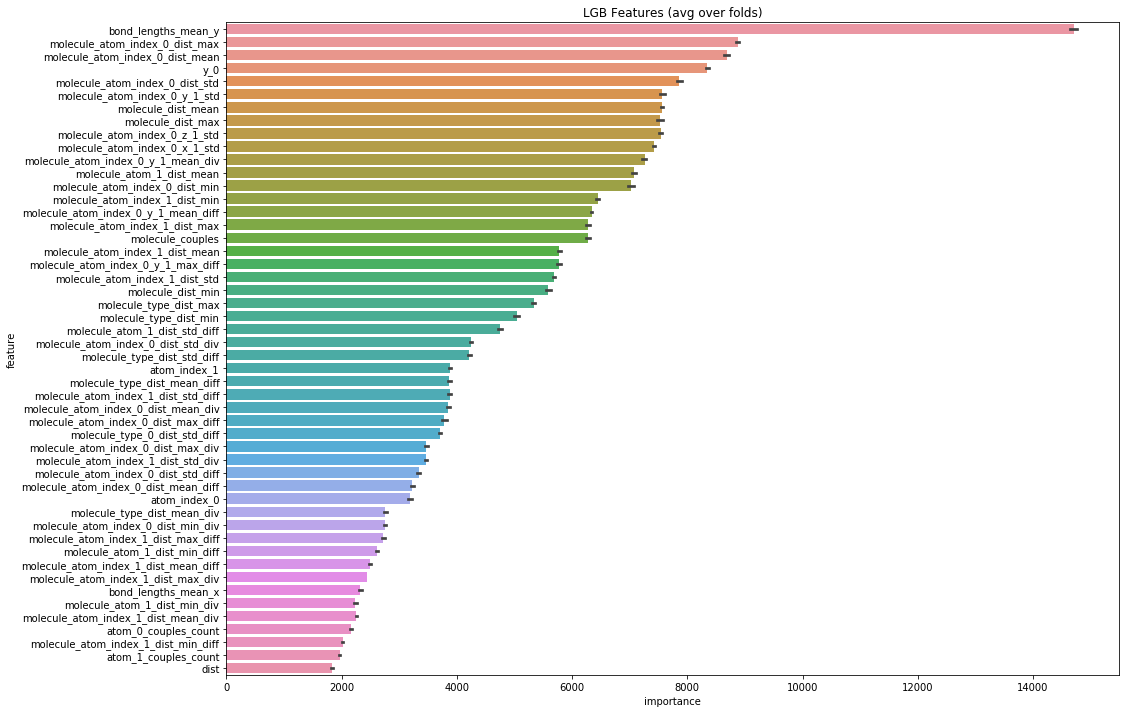

In [42]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb3 = train_model_regression(X=X, X_test=X_test, y=y_pso, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=10000)

In [43]:
oof_pso = result_dict_lgb3['oof']
test_oof_pso = result_dict_lgb3['prediction']

In [44]:
y = y_dso
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [45]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=10000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']

Training of type 0
Fold 1 started at Sun Jun 23 15:03:19 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.014841	valid_1's l1: 0.0175527
[1000]	training's l1: 0.0118423	valid_1's l1: 0.0160434
[1500]	training's l1: 0.00996924	valid_1's l1: 0.0153157
[2000]	training's l1: 0.0086135	valid_1's l1: 0.0148551
[2500]	training's l1: 0.00756031	valid_1's l1: 0.0145313
[3000]	training's l1: 0.00671318	valid_1's l1: 0.0142989
[3500]	training's l1: 0.00601207	valid_1's l1: 0.014123
[4000]	training's l1: 0.00542724	valid_1's l1: 0.0139828
[4500]	training's l1: 0.00493034	valid_1's l1: 0.013872
[5000]	training's l1: 0.00450362	valid_1's l1: 0.0137822
[5500]	training's l1: 0.00413887	valid_1's l1: 0.0137106
[6000]	training's l1: 0.00381645	valid_1's l1: 0.0136462
[6500]	training's l1: 0.00353425	valid_1's l1: 0.0135943
[7000]	training's l1: 0.00328648	valid_1's l1: 0.0135461
[7500]	training's l1: 0.00306867	valid_1's l1: 0.0135092
[8000]	training's l1: 0.002

[500]	training's l1: 0.0380761	valid_1's l1: 0.049893
[1000]	training's l1: 0.0284743	valid_1's l1: 0.0464886
[1500]	training's l1: 0.0224953	valid_1's l1: 0.045013
[2000]	training's l1: 0.0181984	valid_1's l1: 0.0441372
[2500]	training's l1: 0.0149922	valid_1's l1: 0.0436013
[3000]	training's l1: 0.0125066	valid_1's l1: 0.0432127
[3500]	training's l1: 0.0105561	valid_1's l1: 0.0429521
[4000]	training's l1: 0.00900219	valid_1's l1: 0.0427358
[4500]	training's l1: 0.00775294	valid_1's l1: 0.0425789
[5000]	training's l1: 0.00672604	valid_1's l1: 0.0424504
[5500]	training's l1: 0.00588166	valid_1's l1: 0.042364
[6000]	training's l1: 0.00518873	valid_1's l1: 0.0422847
[6500]	training's l1: 0.00461006	valid_1's l1: 0.0422225
[7000]	training's l1: 0.00412885	valid_1's l1: 0.0421714
[7500]	training's l1: 0.00372287	valid_1's l1: 0.0421322
[8000]	training's l1: 0.00338235	valid_1's l1: 0.0420993
[8500]	training's l1: 0.00309179	valid_1's l1: 0.0420731
[9000]	training's l1: 0.00283823	valid_1's

[1000]	training's l1: 0.00160558	valid_1's l1: 0.00399046
[1500]	training's l1: 0.00129968	valid_1's l1: 0.00392452
[2000]	training's l1: 0.00114681	valid_1's l1: 0.00389546
[2500]	training's l1: 0.00105556	valid_1's l1: 0.00387817
[3000]	training's l1: 0.000993232	valid_1's l1: 0.00386809
[3500]	training's l1: 0.000946333	valid_1's l1: 0.00385952
[4000]	training's l1: 0.000909777	valid_1's l1: 0.0038531
[4500]	training's l1: 0.000880568	valid_1's l1: 0.00384811
[5000]	training's l1: 0.000855726	valid_1's l1: 0.00384387
[5500]	training's l1: 0.000834782	valid_1's l1: 0.00384121
[6000]	training's l1: 0.000817042	valid_1's l1: 0.0038388
[6500]	training's l1: 0.000800485	valid_1's l1: 0.00383635
[7000]	training's l1: 0.000786102	valid_1's l1: 0.00383397
[7500]	training's l1: 0.000772742	valid_1's l1: 0.00383099
[8000]	training's l1: 0.000760828	valid_1's l1: 0.00382959
[8500]	training's l1: 0.000749966	valid_1's l1: 0.00382834
[9000]	training's l1: 0.000740006	valid_1's l1: 0.00382713
[95

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0155585	valid_1's l1: 0.017504
[1000]	training's l1: 0.0127956	valid_1's l1: 0.0158833
[1500]	training's l1: 0.0110843	valid_1's l1: 0.0150529
[2000]	training's l1: 0.00981708	valid_1's l1: 0.0145219
[2500]	training's l1: 0.00882214	valid_1's l1: 0.0141484
[3000]	training's l1: 0.00799979	valid_1's l1: 0.013862
[3500]	training's l1: 0.00730847	valid_1's l1: 0.0136442
[4000]	training's l1: 0.00672045	valid_1's l1: 0.0134708
[4500]	training's l1: 0.00621101	valid_1's l1: 0.0133316
[5000]	training's l1: 0.00576545	valid_1's l1: 0.0132204
[5500]	training's l1: 0.00536739	valid_1's l1: 0.0131213
[6000]	training's l1: 0.00501526	valid_1's l1: 0.0130404
[6500]	training's l1: 0.00469787	valid_1's l1: 0.01297
[7000]	training's l1: 0.00441004	valid_1's l1: 0.0129088
[7500]	training's l1: 0.00415054	valid_1's l1: 0.0128525
[8000]	training's l1: 0.00391466	valid_1's l1: 0.0128008
[8500]	training's l1: 0.0037026	v

[1000]	training's l1: 0.0342179	valid_1's l1: 0.0490164
[1500]	training's l1: 0.0282541	valid_1's l1: 0.0470349
[2000]	training's l1: 0.0238779	valid_1's l1: 0.045861
[2500]	training's l1: 0.0204702	valid_1's l1: 0.0450696
[3000]	training's l1: 0.0177453	valid_1's l1: 0.0444952
[3500]	training's l1: 0.015517	valid_1's l1: 0.0440662
[4000]	training's l1: 0.0136617	valid_1's l1: 0.0437365
[4500]	training's l1: 0.0121022	valid_1's l1: 0.0434697
[5000]	training's l1: 0.0107779	valid_1's l1: 0.0432685
[5500]	training's l1: 0.00964344	valid_1's l1: 0.0431145
[6000]	training's l1: 0.00866423	valid_1's l1: 0.0429754
[6500]	training's l1: 0.0078235	valid_1's l1: 0.0428821
[7000]	training's l1: 0.00708874	valid_1's l1: 0.0427818
[7500]	training's l1: 0.00644708	valid_1's l1: 0.0427006
[8000]	training's l1: 0.0058829	valid_1's l1: 0.0426239
[8500]	training's l1: 0.00539331	valid_1's l1: 0.0425604
[9000]	training's l1: 0.00496214	valid_1's l1: 0.0425074
[9500]	training's l1: 0.0045814	valid_1's l1

[2500]	training's l1: 0.018738	valid_1's l1: 0.0283769
[3000]	training's l1: 0.0171889	valid_1's l1: 0.0278852
[3500]	training's l1: 0.0158469	valid_1's l1: 0.0274886
[4000]	training's l1: 0.0146848	valid_1's l1: 0.0271738
[4500]	training's l1: 0.0136558	valid_1's l1: 0.0269109
[5000]	training's l1: 0.0127299	valid_1's l1: 0.0266812
[5500]	training's l1: 0.0119104	valid_1's l1: 0.0264989
[6000]	training's l1: 0.0111742	valid_1's l1: 0.0263412
[6500]	training's l1: 0.0105015	valid_1's l1: 0.0262039
[7000]	training's l1: 0.00988825	valid_1's l1: 0.0260838
[7500]	training's l1: 0.00932584	valid_1's l1: 0.0259835
[8000]	training's l1: 0.00880878	valid_1's l1: 0.0258881
[8500]	training's l1: 0.00833637	valid_1's l1: 0.0258016
[9000]	training's l1: 0.00790017	valid_1's l1: 0.0257276
[9500]	training's l1: 0.00749931	valid_1's l1: 0.0256553
[10000]	training's l1: 0.00712682	valid_1's l1: 0.0256003
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.00712682	valid_1's l1: 0

[2000]	training's l1: 0.00151167	valid_1's l1: 0.00592762
[2500]	training's l1: 0.0013031	valid_1's l1: 0.00589533
[3000]	training's l1: 0.00117138	valid_1's l1: 0.0058751
[3500]	training's l1: 0.00108511	valid_1's l1: 0.00586346
[4000]	training's l1: 0.00102235	valid_1's l1: 0.00585529
[4500]	training's l1: 0.000973767	valid_1's l1: 0.00584855
[5000]	training's l1: 0.00093464	valid_1's l1: 0.00584448
[5500]	training's l1: 0.000902797	valid_1's l1: 0.00584085
[6000]	training's l1: 0.00087668	valid_1's l1: 0.00583685
[6500]	training's l1: 0.000853894	valid_1's l1: 0.00583391
[7000]	training's l1: 0.000834142	valid_1's l1: 0.00583142
[7500]	training's l1: 0.000816714	valid_1's l1: 0.00582913
[8000]	training's l1: 0.000801286	valid_1's l1: 0.00582712
[8500]	training's l1: 0.000787174	valid_1's l1: 0.00582559
[9000]	training's l1: 0.000774594	valid_1's l1: 0.0058239
[9500]	training's l1: 0.00076291	valid_1's l1: 0.00582251
[10000]	training's l1: 0.000751967	valid_1's l1: 0.0058215
Did not 

In [46]:
oof_dso = X_short['oof'].values
test_oof_dso = X_short_test['prediction'].values

Fold 1 started at Sun Jun 23 19:29:13 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0376061	valid_1's l1: 0.0391263
[1000]	training's l1: 0.0328137	valid_1's l1: 0.0352523
[1500]	training's l1: 0.030083	valid_1's l1: 0.0333179
[2000]	training's l1: 0.0280603	valid_1's l1: 0.0319902
[2500]	training's l1: 0.0264679	valid_1's l1: 0.0310308
[3000]	training's l1: 0.0251174	valid_1's l1: 0.0302505
[3500]	training's l1: 0.0239939	valid_1's l1: 0.0296615
[4000]	training's l1: 0.0229779	valid_1's l1: 0.0291513
[4500]	training's l1: 0.0220671	valid_1's l1: 0.0287091
[5000]	training's l1: 0.0212506	valid_1's l1: 0.0283385
[5500]	training's l1: 0.0205164	valid_1's l1: 0.0280257
[6000]	training's l1: 0.0198226	valid_1's l1: 0.0277258
[6500]	training's l1: 0.0191892	valid_1's l1: 0.0274669
[7000]	training's l1: 0.0186032	valid_1's l1: 0.0272364
[7500]	training's l1: 0.0180496	valid_1's l1: 0.0270281
[8000]	training's l1: 0.0175241	valid_1's l1: 0.0268352


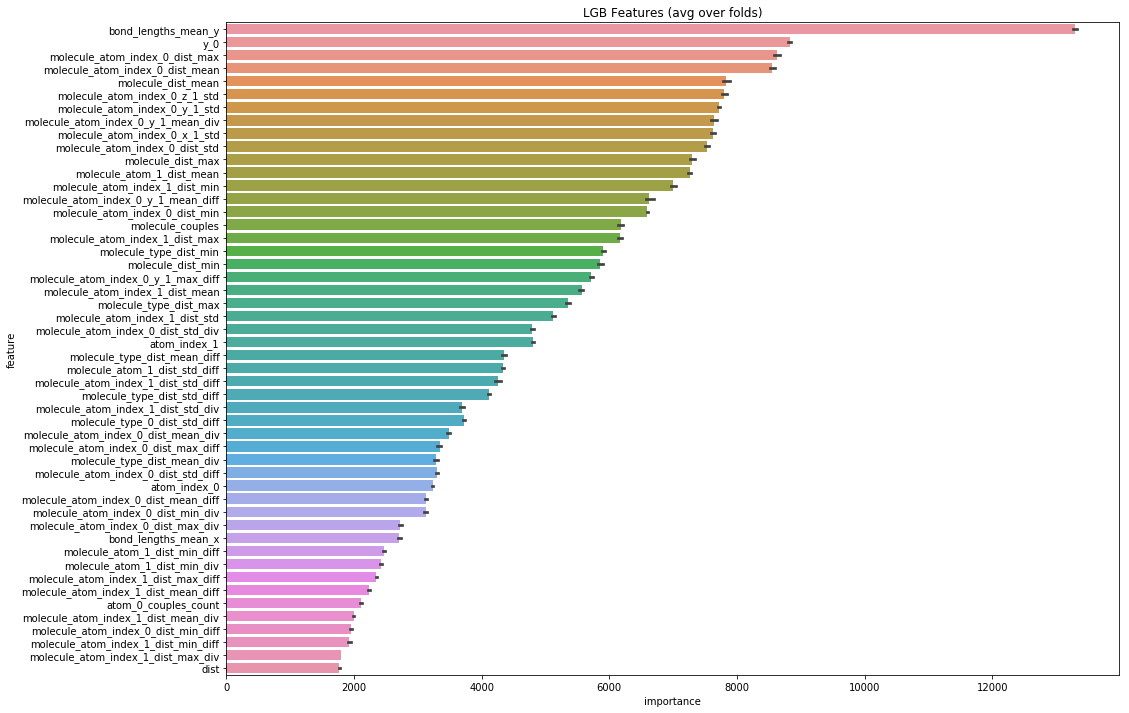

In [47]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb4 = train_model_regression(X=X, X_test=X_test, y=y_dso, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=10000)

In [48]:
oof_dso = result_dict_lgb4['oof']
test_oof_dso = result_dict_lgb4['prediction']

In [49]:
X['oof_fc'] = oof_fc
X_test['oof_fc'] = test_oof_fc

X['oof_sd'] = oof_sd
X_test['oof_sd'] = test_oof_sd

X['oof_pso'] = oof_pso
X_test['oof_pso'] = test_oof_pso

X['oof_dso'] = oof_dso
X_test['oof_dso'] = test_oof_dso

X['oof_scalar_cc'] = X['oof_fc'] + X['oof_sd'] + X['oof_pso'] + X['oof_dso']
X_test['oof_scalar_cc'] = X_test['oof_fc'] + X_test['oof_sd'] + X_test['oof_pso'] + X_test['oof_dso']

In [50]:
del result_dict_lgb1, result_dict_lgb2, result_dict_lgb3, result_dict_lgb4
gc.collect()

45109

Fold 1 started at Sun Jun 23 22:46:13 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0227486	valid_1's l1: 0.0236831
[1000]	training's l1: 0.0214902	valid_1's l1: 0.0231637
[1500]	training's l1: 0.0205248	valid_1's l1: 0.022851
[2000]	training's l1: 0.0197122	valid_1's l1: 0.0226316
[2500]	training's l1: 0.0189855	valid_1's l1: 0.0224407
[3000]	training's l1: 0.0183219	valid_1's l1: 0.0222699
[3500]	training's l1: 0.0177173	valid_1's l1: 0.0221229
[4000]	training's l1: 0.0171542	valid_1's l1: 0.0219878
[4500]	training's l1: 0.0166268	valid_1's l1: 0.0218657
[5000]	training's l1: 0.0161264	valid_1's l1: 0.0217493
[5500]	training's l1: 0.0156672	valid_1's l1: 0.0216445
[6000]	training's l1: 0.0152242	valid_1's l1: 0.0215495
[6500]	training's l1: 0.0148058	valid_1's l1: 0.0214557
[7000]	training's l1: 0.0144123	valid_1's l1: 0.0213766
[7500]	training's l1: 0.0140348	valid_1's l1: 0.0212968
[8000]	training's l1: 0.0136746	valid_1's l1: 0.0212212


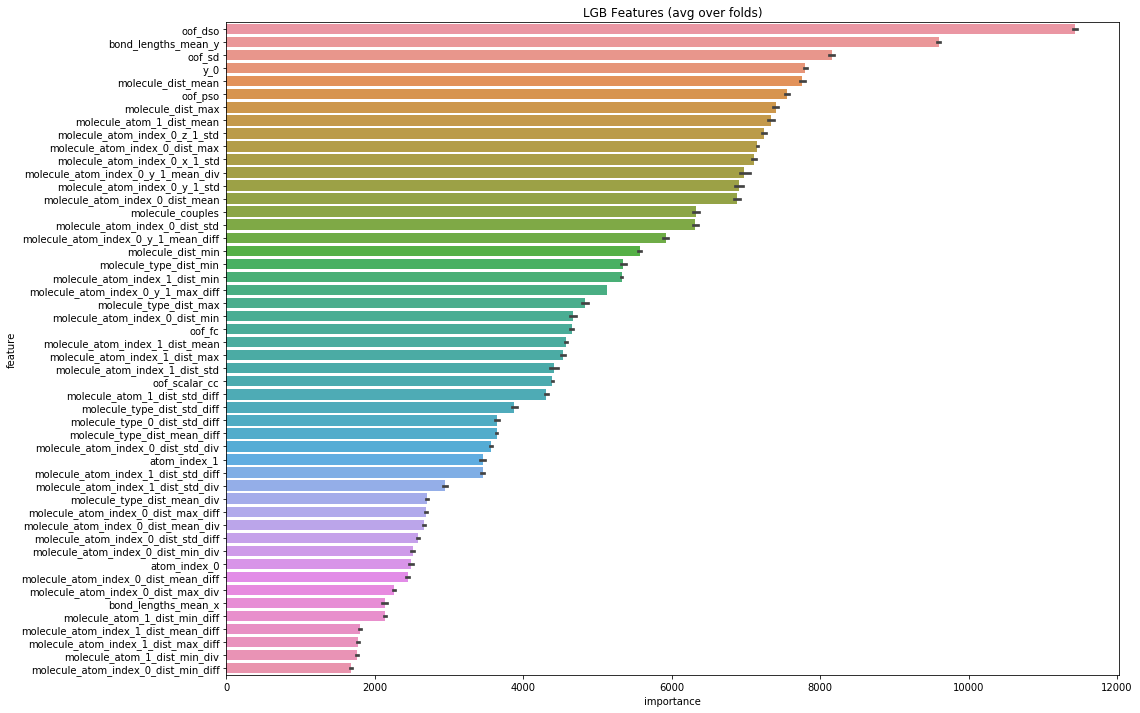

In [51]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=10000)

In [52]:
y = y1
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=10000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('../submissions/sub9.csv', index=False)
sub.head()

Training of type 0
Fold 1 started at Mon Jun 24 02:09:18 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.10387	valid_1's l1: 1.27885
[1000]	training's l1: 0.942226	valid_1's l1: 1.26013
[1500]	training's l1: 0.815698	valid_1's l1: 1.24813
[2000]	training's l1: 0.711886	valid_1's l1: 1.23906
[2500]	training's l1: 0.62699	valid_1's l1: 1.23163
[3000]	training's l1: 0.5539	valid_1's l1: 1.22682
[3500]	training's l1: 0.492136	valid_1's l1: 1.22188
[4000]	training's l1: 0.438783	valid_1's l1: 1.21828
[4500]	training's l1: 0.392404	valid_1's l1: 1.2151
[5000]	training's l1: 0.352148	valid_1's l1: 1.21241
[5500]	training's l1: 0.316924	valid_1's l1: 1.21036
[6000]	training's l1: 0.286025	valid_1's l1: 1.20864
[6500]	training's l1: 0.257912	valid_1's l1: 1.20722
[7000]	training's l1: 0.233438	valid_1's l1: 1.20586
[7500]	training's l1: 0.21164	valid_1's l1: 1.20462
[8000]	training's l1: 0.192022	valid_1's l1: 1.20349
[8500]	training's l1: 0.174448	val

[4500]	training's l1: 0.0416476	valid_1's l1: 0.280842
[5000]	training's l1: 0.035174	valid_1's l1: 0.280517
[5500]	training's l1: 0.029751	valid_1's l1: 0.280271
[6000]	training's l1: 0.0252576	valid_1's l1: 0.280082
[6500]	training's l1: 0.0215623	valid_1's l1: 0.279954
[7000]	training's l1: 0.0184352	valid_1's l1: 0.279831
[7500]	training's l1: 0.0158515	valid_1's l1: 0.279735
[8000]	training's l1: 0.0136939	valid_1's l1: 0.279644
[8500]	training's l1: 0.0118818	valid_1's l1: 0.279586
[9000]	training's l1: 0.0103431	valid_1's l1: 0.279531
[9500]	training's l1: 0.00903288	valid_1's l1: 0.279478
[10000]	training's l1: 0.00792712	valid_1's l1: 0.279433
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.00792712	valid_1's l1: 0.279433
Fold 3 started at Mon Jun 24 03:00:02 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.237668	valid_1's l1: 0.31665
[1000]	training's l1: 0.174701	valid_1's l1: 0.299596
[1500]	training's l1: 

[3000]	training's l1: 0.00794695	valid_1's l1: 0.55429
[3500]	training's l1: 0.00444947	valid_1's l1: 0.554213
[4000]	training's l1: 0.00299155	valid_1's l1: 0.554183
[4500]	training's l1: 0.00236591	valid_1's l1: 0.554158
[5000]	training's l1: 0.00202975	valid_1's l1: 0.554142
Early stopping, best iteration is:
[5245]	training's l1: 0.00191619	valid_1's l1: 0.554137
CV mean score: -0.5888, std: 0.0066.
Training of type 4
Fold 1 started at Mon Jun 24 03:19:57 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.157313	valid_1's l1: 0.307046
[1000]	training's l1: 0.0880718	valid_1's l1: 0.297203
[1500]	training's l1: 0.0527345	valid_1's l1: 0.294101
[2000]	training's l1: 0.0326034	valid_1's l1: 0.292518
[2500]	training's l1: 0.0205754	valid_1's l1: 0.291784
[3000]	training's l1: 0.0132534	valid_1's l1: 0.29137
[3500]	training's l1: 0.00883744	valid_1's l1: 0.291107
[4000]	training's l1: 0.0061129	valid_1's l1: 0.290971
[4500]	training's l1: 0.004450

[4000]	training's l1: 0.237121	valid_1's l1: 0.532322
[4500]	training's l1: 0.216618	valid_1's l1: 0.529303
[5000]	training's l1: 0.198505	valid_1's l1: 0.526745
[5500]	training's l1: 0.182221	valid_1's l1: 0.524581
[6000]	training's l1: 0.167644	valid_1's l1: 0.52285
[6500]	training's l1: 0.154672	valid_1's l1: 0.52135
[7000]	training's l1: 0.142981	valid_1's l1: 0.520058
[7500]	training's l1: 0.13239	valid_1's l1: 0.519002
[8000]	training's l1: 0.122654	valid_1's l1: 0.518132
[8500]	training's l1: 0.113895	valid_1's l1: 0.517236
[9000]	training's l1: 0.105746	valid_1's l1: 0.516541
[9500]	training's l1: 0.0983349	valid_1's l1: 0.515884
[10000]	training's l1: 0.0915338	valid_1's l1: 0.515289
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.0915338	valid_1's l1: 0.515289
Fold 3 started at Mon Jun 24 03:55:11 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.525124	valid_1's l1: 0.59702
[1000]	training's l1: 0.452435	valid

[8000]	training's l1: 0.0320081	valid_1's l1: 0.306562
[8500]	training's l1: 0.0286429	valid_1's l1: 0.30637
[9000]	training's l1: 0.0257125	valid_1's l1: 0.306212
[9500]	training's l1: 0.0231085	valid_1's l1: 0.306034
[10000]	training's l1: 0.0208009	valid_1's l1: 0.305899
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.0208009	valid_1's l1: 0.305899
Fold 4 started at Mon Jun 24 04:51:56 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.286811	valid_1's l1: 0.35192
[1000]	training's l1: 0.226125	valid_1's l1: 0.334113
[1500]	training's l1: 0.185205	valid_1's l1: 0.324788
[2000]	training's l1: 0.155594	valid_1's l1: 0.319065
[2500]	training's l1: 0.132022	valid_1's l1: 0.315132
[3000]	training's l1: 0.113377	valid_1's l1: 0.312354
[3500]	training's l1: 0.0981894	valid_1's l1: 0.310306
[4000]	training's l1: 0.0854399	valid_1's l1: 0.308789
[4500]	training's l1: 0.0747245	valid_1's l1: 0.307501
[5000]	training's l1: 0.0657

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.552984	valid_1's l1: 0.606427
[1000]	training's l1: 0.494351	valid_1's l1: 0.587961
[1500]	training's l1: 0.448124	valid_1's l1: 0.576553
[2000]	training's l1: 0.409255	valid_1's l1: 0.567691
[2500]	training's l1: 0.375896	valid_1's l1: 0.561003
[3000]	training's l1: 0.346623	valid_1's l1: 0.555777
[3500]	training's l1: 0.320903	valid_1's l1: 0.551476
[4000]	training's l1: 0.297708	valid_1's l1: 0.547672
[4500]	training's l1: 0.276975	valid_1's l1: 0.544613
[5000]	training's l1: 0.258124	valid_1's l1: 0.5419
[5500]	training's l1: 0.241035	valid_1's l1: 0.539609
[6000]	training's l1: 0.225535	valid_1's l1: 0.537537
[6500]	training's l1: 0.211349	valid_1's l1: 0.535794
[7000]	training's l1: 0.198149	valid_1's l1: 0.534266
[7500]	training's l1: 0.186077	valid_1's l1: 0.532939
[8000]	training's l1: 0.174951	valid_1's l1: 0.531801
[8500]	training's l1: 0.164596	valid_1's l1: 0.530688
[9000]	training's l1: 

,id,scalar_coupling_constant
0,4658147,8.129784795983502
1,4658148,189.668030725634708
2,4658149,6.816323346698082
3,4658150,191.097685752492623
4,4658151,8.251962439465746


In [53]:
%%time
!kaggle competitions submit -c champs-scalar-coupling -f ../submissions/sub9.csv -m ""

100%|██████████████████████████████████████| 64.0M/64.0M [00:15<00:00, 4.23MB/s]
Successfully submitted to Predicting Molecular PropertiesCPU times: user 590 ms, sys: 0 ns, total: 590 ms
Wall time: 19.6 s


In [54]:
from time import sleep
sleep(60)
!kaggle competitions submissions -c champs-scalar-coupling

fileName   date                 description  status    publicScore  privateScore  
---------  -------------------  -----------  --------  -----------  ------------  
sub9.csv   2019-06-24 01:06:13  None         complete  -1.048       None          
sub8.csv   2019-06-22 07:22:48  None         complete  -0.903       None          
sub7.csv   2019-06-21 07:11:21  None         complete  -1.009       None          
sub6.csv   2019-06-11 10:26:26  None         complete  -0.939       None          
sub5.csv   2019-06-10 01:33:16  None         complete  -0.854       None          
sub4a.csv  2019-06-09 09:26:24  None         complete  -0.830       None          
sub4.csv   2019-06-09 06:05:24  None         complete  -0.603       None          
sub4.csv   2019-06-09 06:03:59  None         complete  -0.196       None          
sub3.csv   2019-06-09 00:57:08  None         complete  -0.376       None          
sub2b.csv  2019-06-08 17:53:30  None         complete  -0.690       None          
sub2

In [55]:
scalar_coupling_contributions.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.022400000000005,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.034700000000001,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.032500000000001,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.031900000000000,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.022199999999998,0.254585,1.25861,0.272013


In [56]:
0.254579	 +  1.25862 + 0.272010 + 83.022400000000005

84.807609